## Total MRI Demand

In [1]:
# Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# optional auto-ARIMA (skip if not installed)
try:
    from pmdarima import auto_arima
    HAS_PMDARIMA = True
except Exception:
    HAS_PMDARIMA = False

FILE_PATH = "TotalMRI_Timeseries.csv"


In [3]:
# Load and basic cleaning
# read csv
df = pd.read_csv(FILE_PATH)

# strip column names and Date values
df.columns = df.columns.str.strip()
df["Date"] = df["Date"].astype(str).str.strip()

# parse Date (DD/MM/YYYY)
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y", errors="coerce")

# numeric Total MRI Scans
df["Total MRI Scans"] = pd.to_numeric(df["Total MRI Scans"], errors="coerce")

# drop rows with missing essentials
df = df.dropna(subset=["Date", "Total MRI Scans"]).sort_values("Date").reset_index(drop=True)


C:\Users\PAVILION\AppData\Local\Temp\ipykernel_38552\2828427082.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key="Date", freq="M"))["Total MRI Scans"]


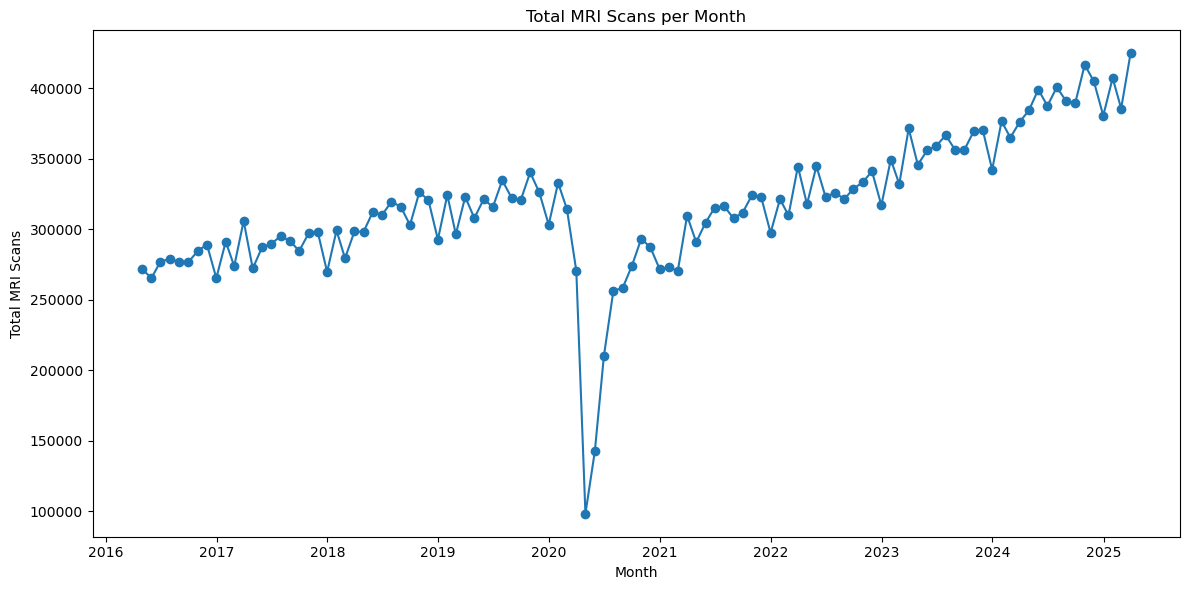

In [4]:
# Monthly aggregation and plot
# monthly sum (end-of-month stamps)
df_monthly = (
    df.groupby(pd.Grouper(key="Date", freq="M"))["Total MRI Scans"]
      .sum()
      .reset_index()
)

plt.figure(figsize=(12, 6))
plt.plot(df_monthly["Date"], df_monthly["Total MRI Scans"], marker="o")
plt.title("Total MRI Scans per Month")
plt.xlabel("Month")
plt.ylabel("Total MRI Scans")
plt.tight_layout()
plt.show()


### STL Decomposition

C:\Users\PAVILION\AppData\Local\Temp\ipykernel_38552\2911107506.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df_monthly.set_index("Date")["Total MRI Scans"].asfreq("M")


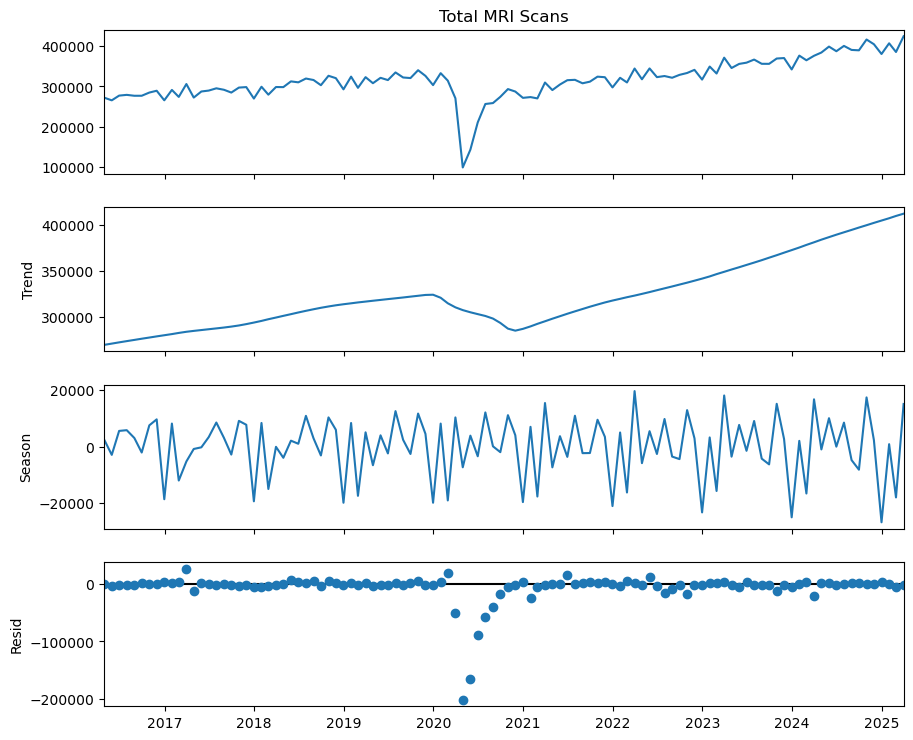

In [5]:
# STL decomposition (seasonal-trend)
df_monthly["Date"] = pd.to_datetime(df_monthly["Date"])
df_monthly = df_monthly.sort_values("Date")
ts = df_monthly.set_index("Date")["Total MRI Scans"].asfreq("M")

stl = STL(ts, period=12, robust=True)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()


### ADF TEst

In [6]:
# Stationarity test (ADF) on original series
adf_result = adfuller(ts.dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
for k, v in adf_result[4].items():
    print(f"Critical Value ({k}): {v:.4f}")
print("Stationary" if adf_result[1] < 0.05 else "Not stationary")


ADF Statistic: -0.0757
p-value: 0.9518
Critical Value (1%): -3.5019
Critical Value (5%): -2.8928
Critical Value (10%): -2.5835
Not stationary


### Difrrencing

In [7]:
# First-difference and ADF on differenced series
ts_diff = ts.diff().dropna()

adf_result_diff = adfuller(ts_diff)
print(f"ADF Statistic (1st diff): {adf_result_diff[0]:.4f}")
print(f"p-value (1st diff): {adf_result_diff[1]:.4f}")
for k, v in adf_result_diff[4].items():
    print(f"Critical Value ({k}): {v:.4f}")
print("Differenced series is stationary" if adf_result_diff[1] < 0.05 else "Differenced series is NOT stationary")


ADF Statistic (1st diff): -3.7848
p-value (1st diff): 0.0031
Critical Value (1%): -3.5019
Critical Value (5%): -2.8928
Critical Value (10%): -2.5835
Differenced series is stationary


### ACF and PACF

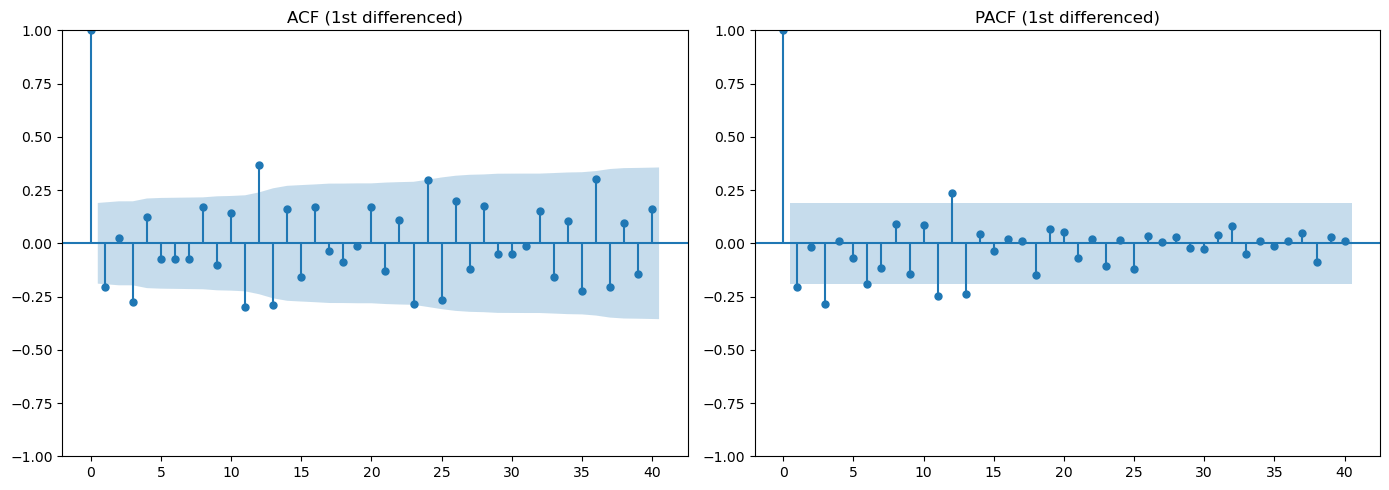

In [8]:
# ACF and PACF on differenced series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(ts_diff, lags=40, ax=axes[0])
axes[0].set_title("ACF (1st differenced)")
plot_pacf(ts_diff, lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF (1st differenced)")
plt.tight_layout()
plt.show()


### Auto ARIMA

In [9]:
# Auto-ARIMA search (optional)
if HAS_PMDARIMA:
    model = auto_arima(
        ts,
        start_p=0, start_q=0, max_p=5, max_q=5,
        d=1,
        start_P=0, start_Q=0, max_P=2, max_Q=2,
        D=1, m=12, seasonal=True,
        stepwise=True, trace=True,
        error_action="ignore", suppress_warnings=True
    )
    print(model.summary())
else:
    print("pmdarima not installed; skipping auto_arima.")


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2231.083, Time=1.28 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2217.485, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2213.981, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2230.959, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2214.044, Time=0.26 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2215.167, Time=0.55 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2217.381, Time=0.06 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2219.610, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2215.763, Time=0.31 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2214.721, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2213.934, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2231.254, Time=0.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=2213.803, Time=0.25 sec
 ARIMA(1,1,0)(2,1,1)[12]

In [10]:
# Train/test split info (last 12 months as test)
ts = ts.sort_index().asfreq("M")
test_size = 12
train = ts.iloc[:-test_size]
test = ts.iloc[-test_size:]

print(f"Train: {train.index.min().date()} → {train.index.max().date()}")
print(f"Test:  {test.index.min().date()}  → {test.index.max().date()}")
print(f"Train size: {len(train)}, Test size: {len(test)}")


Train: 2016-04-30 → 2024-03-31
Test:  2024-04-30  → 2025-03-31
Train size: 96, Test size: 12


C:\Users\PAVILION\AppData\Local\Temp\ipykernel_38552\3917400646.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.sort_index().asfreq("M")


Outlier months replaced: [datetime.date(2020, 4, 30)]


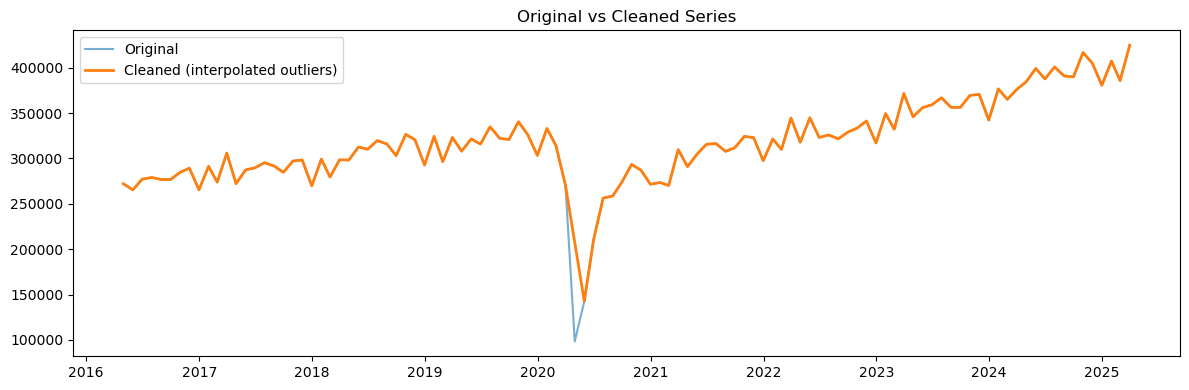

In [11]:
# Outlier smoothing on differences (robust)
# detect extreme moves in differenced series, then interpolate original series on those months
diff = ts.diff()
med = diff.median()
mad = (diff - med).abs().median()
robust_z = 0.6745 * (diff - med) / (mad if mad != 0 else 1)
outlier_idx = robust_z.index[robust_z.abs() > 5]

ts_clean = ts.copy()
ts_clean.loc[outlier_idx] = np.nan
ts_clean = ts_clean.interpolate(method="time")

print(f"Outlier months replaced: {[d.date() for d in outlier_idx]}")

plt.figure(figsize=(12, 4))
plt.plot(ts, label="Original", alpha=0.6)
plt.plot(ts_clean, label="Cleaned (interpolated outliers)", linewidth=2)
plt.title("Original vs Cleaned Series")
plt.legend()
plt.tight_layout()
plt.show()


### SARIMA on Test Data

                                     SARIMAX Results                                      
Dep. Variable:                    Total MRI Scans   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -947.591
Date:                            Thu, 21 Aug 2025   AIC                           1905.181
Time:                                    15:15:37   BIC                           1917.275
Sample:                                04-30-2016   HQIC                          1910.040
                                     - 03-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1215      7.664      0.016      0.987     -14.900      15.143
ma.L1         -0.1112      7.703   

d:\APPLICATIONS\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


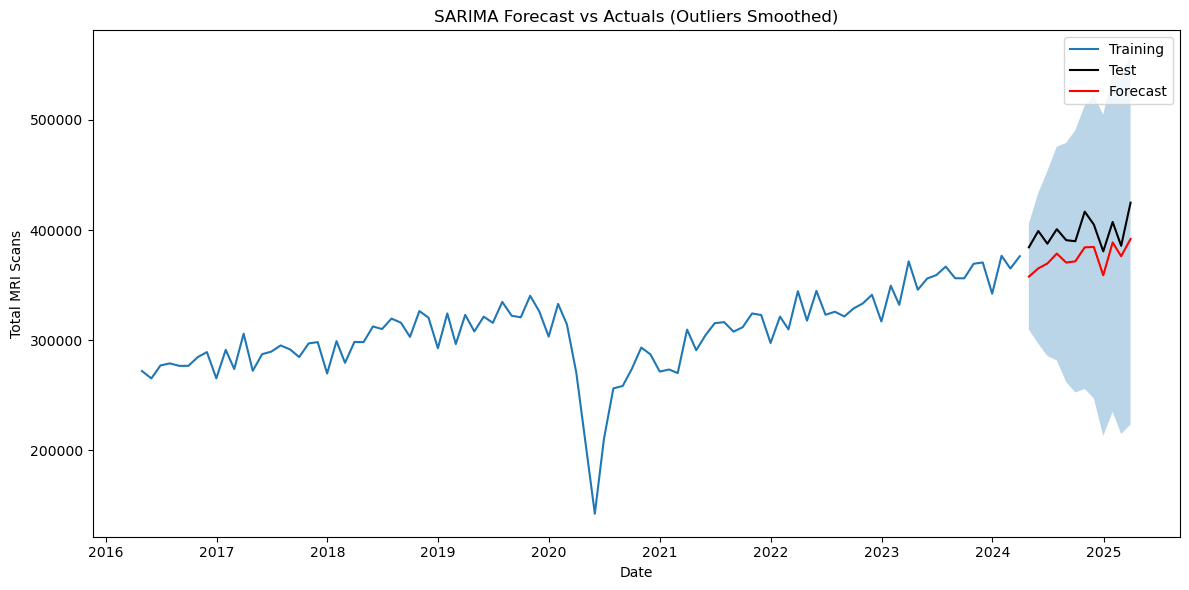

In [12]:
# SARIMA fit on cleaned train, forecast test, and evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error

train = ts_clean.iloc[:-test_size]
test  = ts_clean.iloc[-test_size:]

model = sm.tsa.SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=True,
    enforce_invertibility=True
)
model_fit = model.fit(disp=False)
print(model_fit.summary())

n_test = len(test)
fc = model_fit.get_forecast(steps=n_test)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

rmse = mean_squared_error(test, fc_mean, squared=False)
mae  = mean_absolute_error(test, fc_mean)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE:  {mae:,.2f}")

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Training")
plt.plot(test.index,  test,  label="Test", color="black")
plt.plot(test.index,  fc_mean, label="Forecast", color="red")
plt.fill_between(test.index, fc_ci.iloc[:, 0], fc_ci.iloc[:, 1], alpha=0.3)
plt.title("SARIMA Forecast vs Actuals (Outliers Smoothed)")
plt.xlabel("Date")
plt.ylabel("Total MRI Scans")
plt.legend()
plt.tight_layout()
plt.show()


### SARIMA on entire data to forecast future years

C:\Users\PAVILION\AppData\Local\Temp\ipykernel_38552\3232050301.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_clean = ts_clean.sort_index().asfreq("M")


                                     SARIMAX Results                                      
Dep. Variable:                    Total MRI Scans   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1080.507
Date:                            Thu, 21 Aug 2025   AIC                           2171.014
Time:                                    15:16:21   BIC                           2183.783
Sample:                                04-30-2016   HQIC                          2176.173
                                     - 03-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0184     18.138      0.001      0.999     -35.531      35.568
ma.L1         -0.0227     18.102   

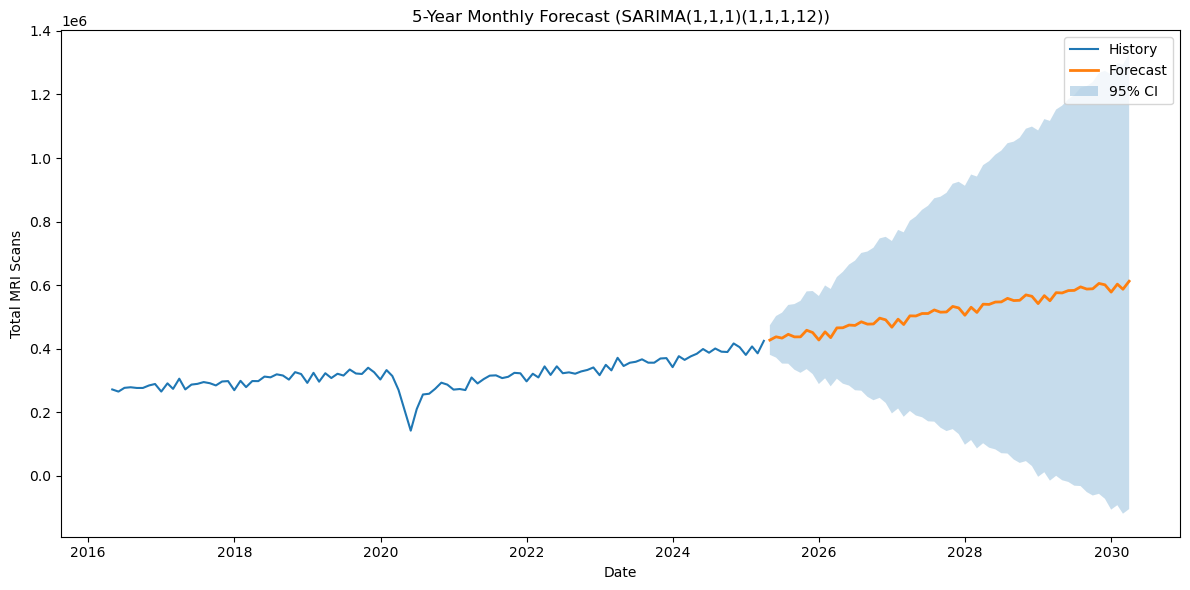

In [13]:
# %% Refit on full cleaned history and 5-year (60-month) forecast
ts_clean = ts_clean.sort_index().asfreq("M")

final_model = sm.tsa.SARIMAX(
    ts_clean,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=True,
    enforce_invertibility=True
).fit(disp=False)

print(final_model.summary())

h = 60
fc = final_model.get_forecast(steps=h)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()
ci_lower = fc_ci.iloc[:, 0]
ci_upper = fc_ci.iloc[:, 1]

forecast_df = pd.DataFrame({
    "Forecast": fc_mean,
    "Lower_95": ci_lower,
    "Upper_95": ci_upper
})
forecast_df.to_csv("mri_forecast_5y.csv", index_label="Date")

plt.figure(figsize=(12, 6))
plt.plot(ts_clean.index, ts_clean, label="History")
plt.plot(fc_mean.index, fc_mean, label="Forecast", linewidth=2)
plt.fill_between(fc_mean.index, ci_lower, ci_upper, alpha=0.25, label="95% CI")
plt.title("5-Year Monthly Forecast (SARIMA(1,1,1)(1,1,1,12))")
plt.xlabel("Date")
plt.ylabel("Total MRI Scans")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# %% Yearly totals from monthly forecast (in millions)
# assumes forecast_df exists from the previous cell
forecast_df = forecast_df.copy()
forecast_df.index = pd.to_datetime(forecast_df.index)
forecast_df = forecast_df.asfreq("M")

yearly_totals = (
    forecast_df[["Forecast", "Lower_95", "Upper_95"]]
    .resample("Y")
    .sum()
)

counts = forecast_df["Forecast"].resample("Y").count()
yearly_totals_full = yearly_totals[counts == 12]

def to_millions(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.div(1_000_000)
    out.index = out.index.year
    out.index.name = "Year"
    out = out.rename(columns=lambda c: f"{c} (Millions)")
    return out.round(2)

yearly_totals_m      = to_millions(yearly_totals)
yearly_totals_full_m = to_millions(yearly_totals_full)

print("Yearly totals (includes partial years):")
print(yearly_totals_m)
print("\nYearly totals (full 12-month years only):")
print(yearly_totals_full_m)

yearly_totals_m.to_csv("mri_forecast_yearly_totals_all_in_millions.csv", float_format="%.2f")
yearly_totals_full_m.to_csv("mri_forecast_yearly_totals_full_years_in_millions.csv", float_format="%.2f")


Yearly totals (includes partial years):
      Forecast (Millions)  Lower_95 (Millions)  Upper_95 (Millions)
Year                                                               
2025                 3.96                 3.06                 4.85
2026                 5.66                 3.17                 8.16
2027                 6.12                 1.99                10.25
2028                 6.56                 0.79                12.33
2029                 6.99                -0.44                14.43
2030                 1.80                -0.31                 3.92

Yearly totals (full 12-month years only):
      Forecast (Millions)  Lower_95 (Millions)  Upper_95 (Millions)
Year                                                               
2026                 5.66                 3.17                 8.16
2027                 6.12                 1.99                10.25
2028                 6.56                 0.79                12.33
2029                 6.99        

C:\Users\PAVILION\AppData\Local\Temp\ipykernel_38552\1506589256.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_df = forecast_df.asfreq("M")
C:\Users\PAVILION\AppData\Local\Temp\ipykernel_38552\1506589256.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("Y")
C:\Users\PAVILION\AppData\Local\Temp\ipykernel_38552\1506589256.py:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  counts = forecast_df["Forecast"].resample("Y").count()
